## Mask R-CNN:
It is a two stage framework: 
1. Scans the image and generates proposals (areas likely to contain an object)
2. Classifies the proposal and generates bounding boxes and masks

Configurations and data loading for MR COCO.

# 1. Define Useful Boilerplate Functions

In [6]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);  # 1.6.0+cu101 True

2.0.1 False


In [162]:
import torch

if torch.cuda.is_available():
    print("CUDA (GPU) is available")
else:
    print("CUDA (GPU) is not available")


CUDA (GPU) is not available


In [7]:
import torchvision.transforms as T

# standad Pytorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [20]:
# for output bounding box post-processing

# converts bbox coordinates from one format to another
# from "center-x, center-y, width, height" format (cx, cy, w, h) 
# to "top-left x, top-left y, bottom-right x, bottom-right y"
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5*w), (y_c - 0.5*h),
        (x_c + 0.5*w), (y_c + 0.5*h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b                   

In [9]:
def filter_bboxes_from_outputs(outputs, threshold=0.7):

    # keep only predictions with confidence above threshold
    probas = output['pred_logits'].softmax(-1)[0, :, :-1]     # selecting only the first batch
    keep = probas.max(-1).values > threshold
    
    probas_to_keep = probas[keep]
    
    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas_to_keep, bboxes_scaled

In [32]:
# COCO Classes
#CLASSES = ['N/A', 'LeftEye', 'RightEye']
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [33]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100

    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
    
            cl = p.argmax()
            text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                   bbox=dict(facecolor='yellow', alpha=0.5))
        plt.axis('off')
        plt.show()

# 2. Detection - Using a pre-trained model from TorchHub (DETR-R50)

In [39]:
# Load model from hub, run it on a custom image and print the results. 
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in /Users/sarvzz/.cache/torch/hub/facebookresearch_detr_main


In [35]:
# retrieve the image as a PIL 
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

### 2.1 Apply image pre-processing, run it through the model and filter the predictions

In [36]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

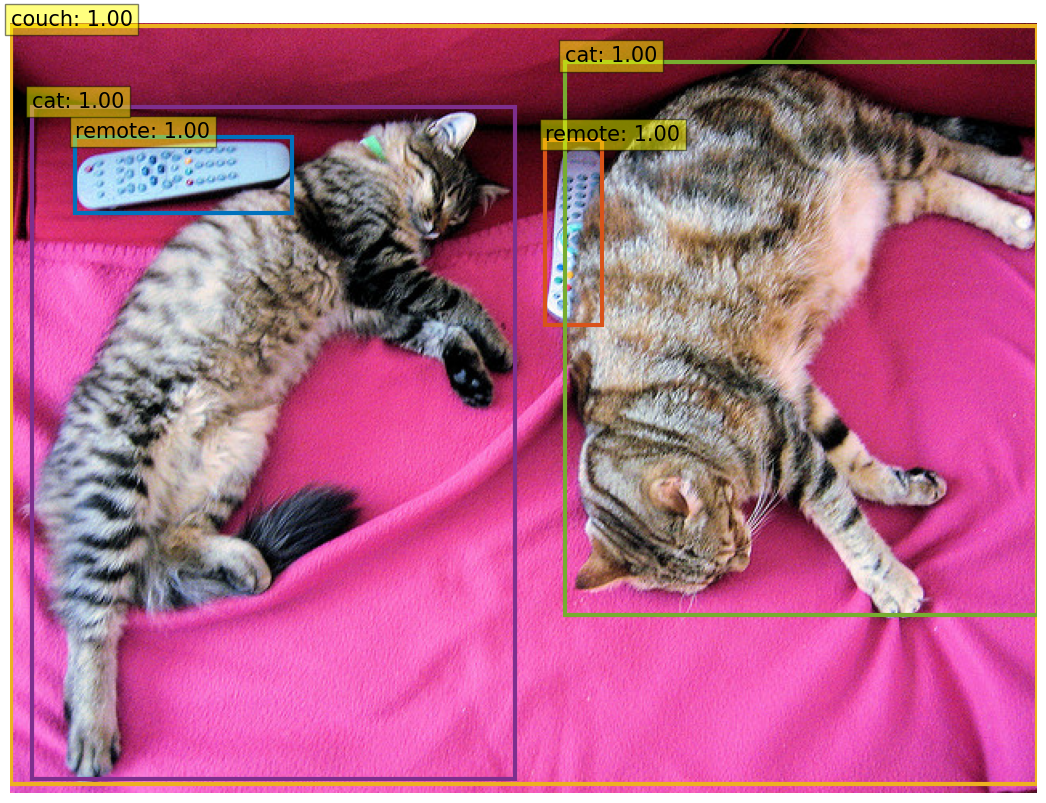

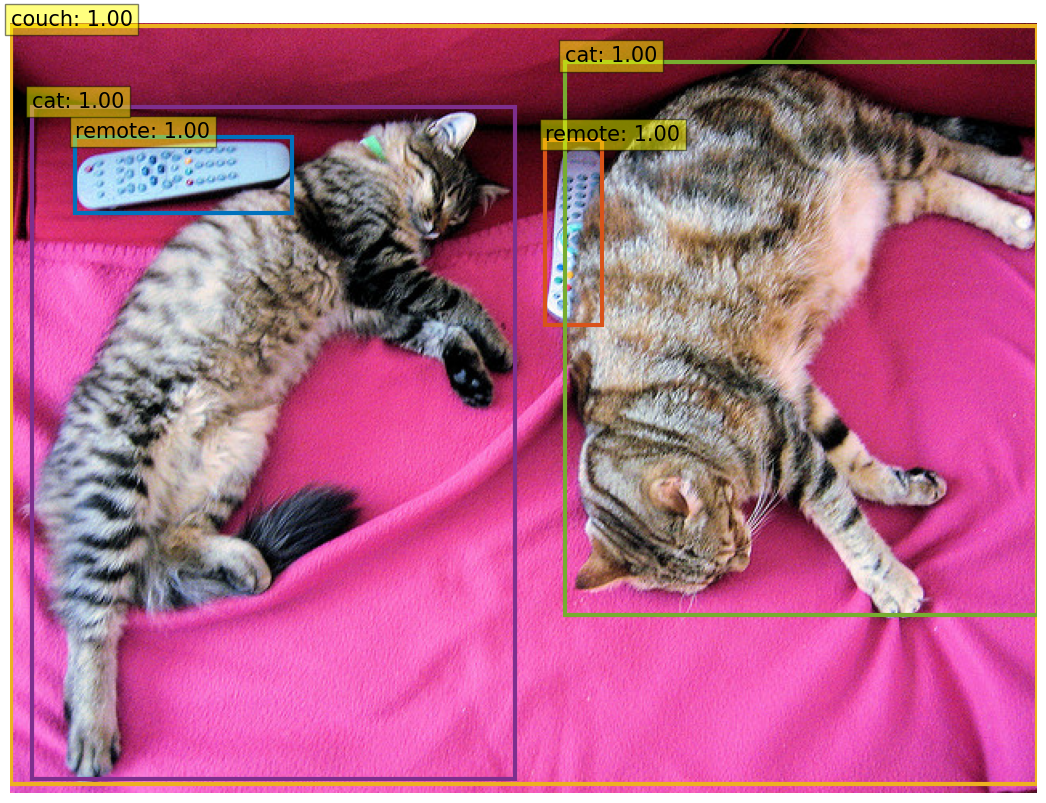

In [38]:
for threshold in [0.9, 0.7]:
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, threshold=threshold)

    plot_results(im, probas_to_keep, bboxes_scaled)

# 3. Load pre-trained weights

In [40]:
# # replacing classification head, as there are only 3 classes. Max 2 per image
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=False, num_classes=3)

# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
    map_location='cpu',
    check_hash=True)
  
# Remove class weights
del checkpoint['model']['class_embed.weight']
del checkpoint['model']['class_embed.bias']

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

Using cache found in /Users/sarvzz/.cache/torch/hub/facebookresearch_detr_main


In [45]:
# Set non-strict weight loading 
#model_without_ddp.load_state_dict(checkpoint['model'], strict=False)

# 4. Prepare the Dataset for fine-tuning

### 4.1 Convert LabelMe to COCO

In [5]:
# Update labels to 'Iris'
import json
import os

folder_path = 'labels'

# iterate over all files in the folder: 
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)

        # Load the json file
        with open(file_path, 'r') as file:
            data = json.load(file)

        # Iterate over shapes and update labels
        for shape in data['shapes']:
            if shape['label'] == 'LeftEye' or shape['label'] == 'RightEye':
                shape['label'] = 'Iris'

        # Save the updated JSON file
        with open(file_path, 'w') as file:
            json.dump(data, file, indent=2)

In [163]:
pip install -U labelme2coco

Note: you may need to restart the kernel to use updated packages.


In [1]:
import labelme2coco

/Users/sarvzz/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# input folder 
labelme_folder = 'upload_data/labels'

# output folder
export_dir = 'upload_data/coco-annotation/'

# convert labelme annotations to coco
labelme2coco.convert(labelme_folder, export_dir)

There are 750 listed files in folder labels.


Converting labelme annotations to COCO format: 100%|█| 750/750 [00:00<00:00, 210
12/07/2023 12:31:33 - INFO - labelme2coco -   Converted annotations in COCO format is exported to upload_data/coco-annotation/dataset.json


In [125]:
first_class_index = 0

In [133]:
%matplotlib inline 
import pycocotools.coco as coco 
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize']=(10.0,8.0)

In [153]:
# Define Dataset and path
dataDir = 'data/train/'
dataType = 'images'
annFile = '{}coco_annotation/dataset.json'.format(dataDir)
imgDir = '{}{}'.format(dataDir, dataType)

In [154]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [155]:
# getImgIds, getCatIds, loadImgs, loadCats

# display COCO categories and supercategories 
cats = coco.loadCats(coco.getCatIds())

nms = [cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('super-categories: {}'.format(nms))

Categories: ['Eye']
super-categories: {'Eye'}


In [156]:
# load and display image
catIds = coco.getCatIds(catNms=['eyes']);
imgIds = coco.getImgIds(catIds=catIds);

Image n°1
Image name: data/train//images/../images/train_image.jpg


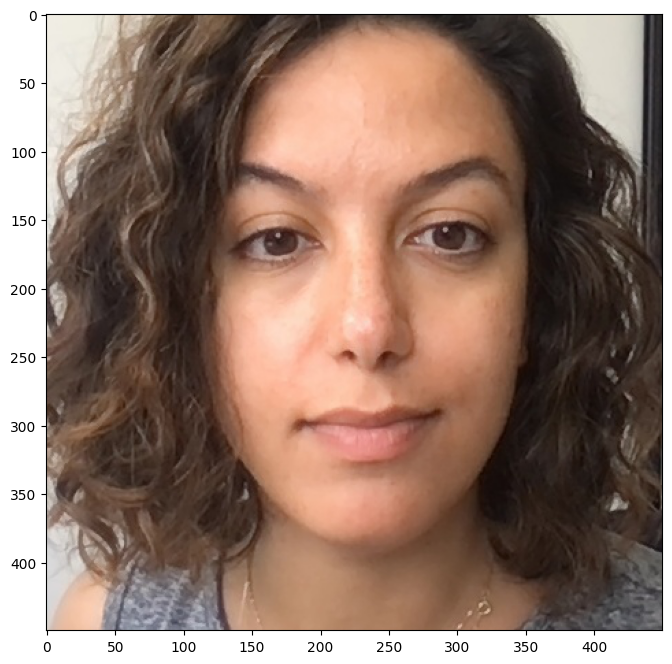

In [157]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [158]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

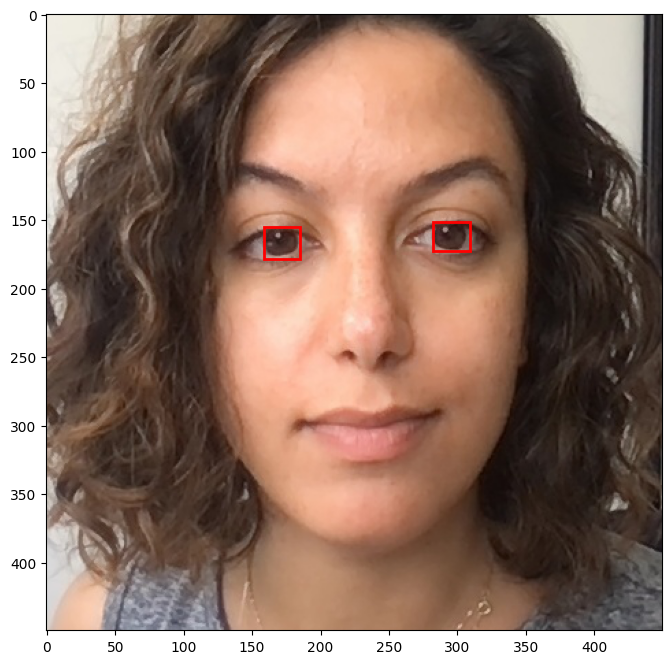

In [159]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.imshow(I)

# Add bounding boxes
for ann in anns:
    bbox = ann['bbox']
    x, y, w, h = bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.show()


In [47]:
from pathlib import Path
import argparse

parser = argparse.ArgumentParser(description='pointing to the dataset')
parser.add_argument('--coco_path', type=str, default='aug_data/')
args = parser.parse_args()

def build_your_dataset(image_set, args):
    root = Path(args.coco_path)
    assert root.exists(), f'provided COCO path {root} does not exist'
    mode = 'instances'
    PATHS = {
        "train": (root / "train", root / "annotations" / f'train.json'),
        "val": (root / "valid", root / "annotations" / f'valid.json'),
    }

    img_folder, ann_file = PATHS[image_set]
    dataset = CocoDetection(img_folder, ann_file, transforms=make_coco_transforms(image_set), return_masks=args.masks)
    return dataset

usage: ipykernel_launcher.py [-h] [--coco_path COCO_PATH]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/sarvzz/Library/Jupyter/runtime/kernel-ac25579c-f8e3-49b5-8ae1-31854f90ffa7.json


SystemExit: 2

/Users/sarvzz/miniconda3/envs/iris/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 5. Model Fune-tuning

In [161]:
assert(first_class_index in [0,1])

if first_class_index == 0:
    num_classes = 1
    finetuned_classes = ['Eye',]

else:
    num_classes = 2
    finetuned_classes = [
        'N/A','Eye'
    ]

print('First class index: {}'.format(first_class_index))
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 1
Fine-tuned classes: ['Eye']


# 6. Monitoring of training